## Import all required libraries

In [1]:
from datetime import datetime
import serial
import csv
import os
import keyboard
import numpy as np
import pandas as pd
from scipy import stats as st
from pykalman import KalmanFilter
import plotly.graph_objects as go
from joblib import load
import warnings
warnings.filterwarnings('ignore')


Store raw data in CSV file

In [2]:
print('\nWaiting for data from Arduino serial port')
print('------------------------------------------\n')

current_time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
value = 0
file_path = r'./Raw data'
file_name = f"{current_time}.csv"
file_full_path = os.path.join(file_path, file_name)

# Write the header to the CSV file
header = ['sr_no', 'timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'mag_x', 'mag_y', 'mag_z', 'event_class']

with open(file_full_path, 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)

# Open serial port
ser = serial.Serial('COM4', 115200)
ser.flush()

try:
    while True:
        received_string = ser.readline().decode('utf-8').strip()  # Get the data from Arduino serial port
        mpu_values = received_string.split('|')  # Split the string into 9 values at '|'
        now = datetime.now().strftime("%d-%m-%Y %H:%M:%S:%f")
        value += 1
        sr_no = str(value)
        data_row = [sr_no, now] + mpu_values
        with open(file_full_path, 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(data_row)
        print(data_row)

        # Check if the 'esc' key was pressed to stop capturing data
        if keyboard.is_pressed('esc'):
            break

except Exception as e:
    print(f"An error occurred: {str(e)}")

finally:
    # Close the serial port
    ser.close()



Waiting for data from Arduino serial port
------------------------------------------

['1', '14-07-2023 12:34:36:325673', '-0.969028', '0.314917', '-0.304789', '-0.069321', '0.001037', '-0.003029', '54.022350', '92.273582', '104.914329', '0']
['2', '14-07-2023 12:34:41:099639', '-0.978608', '0.439460', '-0.208986', '-0.068522', '0.001303', '0.000167', '54.022350', '92.273582', '104.914329', '0']
['3', '14-07-2023 12:34:41:103637', '-0.892387', '0.362818', '-0.410172', '-0.069321', '-0.001094', '0.000433', '84.556724', '87.808731', '86.668365', '0']
['4', '14-07-2023 12:34:41:108644', '-0.921127', '0.477781', '-0.266468', '-0.070386', '-0.001094', '0.000433', '84.556724', '87.808731', '86.668365', '0']
['5', '14-07-2023 12:34:41:112632', '-0.777424', '0.314917', '-0.525133', '-0.070386', '0.001570', '0.004961', '103.347122', '96.738433', '75.264633', '0']
['6', '14-07-2023 12:34:41:140614', '-0.806164', '0.276596', '-0.247309', '-0.069321', '0.001303', '0.003097', '103.347122', '96.738

## Visualization of sensor data

In [3]:
variables_dict = {
    'acc_x': 'X axis of Accelerometer', 
    'acc_y': 'Y axis of Accelerometer',
    'acc_z': 'Z axis of Accelerometer', 
    'gyro_x': 'X axis of Gyroscope',
    'gyro_y': 'Y axis of Gyroscope', 
    'gyro_z': 'Z axis of Gyroscope',
    'mag_x': 'X axis of Magnetometer', 
    'mag_y': 'Y axis of Magnetometer',
    'mag_z': 'Z axis of Magnetometer'
    }

# Here \u00B2 mean ^2 and \u03BC micro symbol

units_dict = {
    'acc_x': 'm/s\u00B2', 
    'acc_y': 'm/s\u00B2', 
    'acc_z': 'm/s\u00B2',
    'gyro_x': 'rad/sec', 
    'gyro_y': 'rad/sec', 
    'gyro_z': 'rad/sec',
    'mag_x': '\u03BC T', 
    'mag_y': '\u03BC T', 
    'mag_z': '\u03BC T'}

def update_layout(fig, chart_title: str, **kwargs):
    """Update layout for every chart

    Args:
        fig: A plotly figure
        chart_title (str): A title for chart

    Returns:
        fig: the updated layout for the plotly figure
    """
    # Get kwards data if is needed
    x_title = kwargs.get('xaxis_title', None)
    y_title = kwargs.get('yaxis_title', None)
    height_size = kwargs.get('height', 400)

    # Update layout of the figure
    fig.update_layout(
        title={'text': chart_title, 'x': 0.5},
        legend_title='Driving Data',
        xaxis_title=x_title,
        yaxis_title=y_title,
        template='plotly_white',
        autosize=True,
        height=height_size,
        font=dict(
            family="BlinkMacSystemFont,-apple-system,Segoe UI,Roboto,Oxygen,Ubuntu",
            size=14,
            color="#363636"
        )
    )
    return fig

def line_chart(df, variable):
    """Line chart created with plotly graphic object

    Args:
        df (DataFrame): The dataframe that contains the data to plot
        variable (str): The specific variable to plot

    Returns:
        fig: A plotly figure
    """
    # Create a copy of the data frame to avoid losing important data
    normal_event_df = df.copy()
    x = df['timestamp']

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=x,
        y=normal_event_df[variable],
        name='Driving Data',
        marker_color='#64CCC5',
        text=normal_event_df["sr_no"],
        hovertemplate="X = %{x}<br>Y = %{y}<br>SR-NO = %{text}"
    ))
    fig = update_layout(fig, f'Plot of {variables_dict[variable]}',
                        xaxis_title='Event Time', yaxis_title=units_dict[variable])
    fig.update_yaxes(nticks=12)
    fig.update_xaxes(nticks=12, tickangle=45)

    return fig

# Loading raw sensor data from CSV file
df = pd.read_csv(file_full_path)

# selecting required variables from dataset to plot
variables = ['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z','mag_x','mag_y',
             'mag_z']

for var in variables:
    fig = line_chart(df, var)
    fig.show()

## Sliding window algorithm

In [4]:
def sliding_windows(df, features, window_size=40):
    """Create a sliding window with a defined window size and return the calculation for each record inside the sliding window.
    
    The calculations made are for each time window: 
    - The mean.
    - The median.
    - The standard deviation.
    - The maximum and minimum value.
    - The trend.
    Args:
        dataset (numpy.array): An array with the data taken on a vehicle trip, 
        composed for rows: dataset registers and columns: first data index, and subsequent dataset event features.
        window_size (int, optional): number Number of registers contained in the time window. Defaults to 40.
        event_features (str, optional): the names of dataset features. Defaults to "X".
    Returns:
        tuple: A tuple structured like this: (sliding window id, sliding window featured data, sliding window label data, features name)"""
        
    feature = ["sr_no", *features,  "event_class"]
    dataset = df[feature].to_numpy()
    sld_window = np.lib.stride_tricks.sliding_window_view(dataset, window_size, axis=0) #[::1, :] Add this for define window step
    # Splitting dataset id
    id = sld_window[:,0:1,:]
    sld_window_id = np.concatenate((id[:,:,0], id[:,:,-1]), axis=1) # get the first and last id from registers in every sliding window
    # Splitting the dataset (features, label)
    separator = dataset.shape[1] - 1 # Removing the last column corresponding to the event_class 
    features_data = sld_window[:, 1:separator, :] # Get the features of the data in every sliding window
    label_data = sld_window[:, separator, :] # Get the labels of the data in every sliding window
    
    # Processing the sliding window
    # Get the mean, median, std, max and min value
    mean = features_data.mean(axis=2)
    median = np.median(features_data, axis=2)
    std = features_data.std(axis=2)
    max_val = features_data.max(axis=2)
    min_val = features_data.min(axis=2)
    # Get tendency, which is the current value divided by the previous value.
    # Taking the mean value of the first record in the sliding window and all previous mean values.
    divider = np.array([mean[0], *mean[:-1]])
    # Dividing the mean array by the divider array. 
    tend = mean/np.where(divider == 0, 1, divider) # Replace any zero value in the divider array with 1.
    
    label = st.mode(label_data, axis=1)[0]
    # Concatenate processed sliding window
    sld_window_features = np.concatenate((mean, median, std, max_val, min_val, tend), axis=1)
    # Reshape label for sklearn standard
    label = label.reshape(label.shape[0])
    
    # Make input algorithm df
    x = pd.DataFrame(sld_window_features)
    x[["first","last"]] = sld_window_id
    x.set_index(["first","last"], inplace=True)

    return (x, label)

## Kalman filtering

In [5]:
def data_filter(df):
    features = ["acc_x", "acc_y", "gyro_z", "mag_x", "mag_y"]

    for var in features:
        # Check for missing values
        # df.dropna(inplace=True)
        data = df[var]
        # Kalman filter process
        kf = KalmanFilter(initial_state_mean = data.iloc[0], n_dim_obs=1)
        filter_data = kf.em(data).filter(data)[0].T[0]
        filter_data_s = pd.Series(np.array(filter_data), name=var)
        df[var] = filter_data_s

        # Normalized magnetometer data with min-max normalization
        if var == "mag_x" or var =="mag_y":
            normalized_data = (data-data.min())/(data.max()-data.min())
            df[var] = normalized_data

    return df

## Algorithm to detect harsh driving events

In [6]:
df = pd.read_csv(file_full_path)

models = ["model_sudden_acceleration",
          "model_sudden_braking",
          "model_sudden_right_line",
          "model_sudden_left_line",
          "model_sudden_right_turn",
          "model_sudden_left_turn"]

features = [["acc_y"],
            ["acc_y"],
            ["acc_x", "gyro_z"],
            ["acc_x", "gyro_z"],
            ["acc_x" ,"acc_y", "gyro_z", "mag_x", "mag_y"],
            ["acc_x" ,"acc_y", "gyro_z", "mag_x", "mag_y"]]

event_labels = ["Sudden Braking",
                "Sudden Acceleration",
                "Sudden Line Changing",
                "Sudden Turning"]

now = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f"Machine Learning - [{now}] \"Starting Kalman Filtering\"")

# Applying kalman filtering to raw data
df_filtered = data_filter(df)

now = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f"Machine Learning - [{now}] \"Kalman filter finished\"")

now = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f"Machine Learning - [{now}] \"Starting Machine Learning\"")

Harsh_drive = {}
event_counts = {}  # Dictionary to store the count of each event label

for c, f, event_label in zip(models, features, event_labels):
    # Feature extraction using sliding window
    x, y = sliding_windows(df_filtered, f, 50)

    # Loading built machine learning models to detect harsh driving events
    model = load(str("./built models/" + c + ".joblib"))
    prediction = model.predict(x.values)
    prediction_proba = model.predict_proba(x.values)[:, 1]

    if len(np.where(prediction == 1.0)[0]) != 0:
        Harsh_drive_df = x.iloc[np.where(prediction == 1.0)[0]]
        Harsh_drive[event_label] = Harsh_drive_df

        # Count the occurrences of the event label
        count = 0
        for p in prediction:
            if p == 1.0:
                count += 1
            else:
                if count >= 50:  # If consecutive count is 50 or more, count it as 1
                    event_counts[event_label] = event_counts.get(event_label, 0) + 1
                count = 0

        if count >= 50:  # Check for the last sequence as well
            event_counts[event_label] = event_counts.get(event_label, 0) + 1

now = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print(f"Machine Learning - [{now}] \"Machine Learning finished\"")

# Determine the driving event responsible for harsh driving
if len(Harsh_drive) > 0:
    max_event = max(Harsh_drive, key=lambda x: len(Harsh_drive[x]))
    print("\nThe driving event most likely responsible for harsh driving is:", max_event)
else:
    print("\nNo harsh driving events detected.")

# Print the count of each event label
for event_label, count in event_counts.items():
    print(f"{event_label}, Count: {count}")


Machine Learning - [14/07/2023 12:38:27] "Starting Kalman Filtering"
Machine Learning - [14/07/2023 12:40:31] "Kalman filter finished"
Machine Learning - [14/07/2023 12:40:31] "Starting Machine Learning"
Machine Learning - [14/07/2023 12:40:42] "Machine Learning finished"

The driving event most likely responsible for harsh driving is: Sudden Line Changing
Sudden Braking, Count: 1
Sudden Line Changing, Count: 5
Sudden Turning, Count: 2


## Result visualization

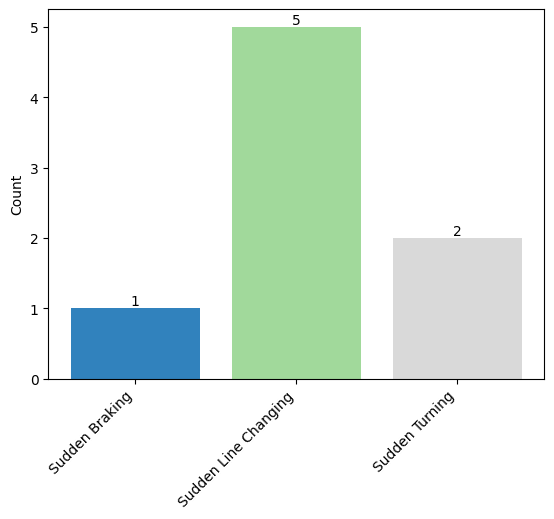

In [7]:
import matplotlib.pyplot as plt

# Plot the count of each event label
event_labels = list(event_counts.keys())
event_counts = list(event_counts.values())

fig, ax = plt.subplots()

# Set custom colors for each event label
colors = plt.cm.get_cmap('tab20c', len(event_labels))

# Create a bar plot with custom colors
bars = ax.bar(range(len(event_labels)), event_counts, color=colors(np.arange(len(event_labels))))

# Customize the graph
ax.set_ylabel('Count')
# ax.set_title('Count of Harsh Driving Events')
ax.set_xticks(range(len(event_labels)))
ax.set_xticklabels(event_labels, rotation=45, ha='right')

# Add data labels above each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, str(event_counts[i]), ha='center', va='bottom')

# Show the plot
plt.show()
